<h1><u>Advancedn topics in ML - Assignment III - task A</u></h1>
<h4>Omer Nivron</h4>
15098443

In [1]:
import gym
import numpy as np
import random
import tensorflow as tf
import itertools
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt # side-stepping mpl backend
import matplotlib.gridspec as gridspec # subplots
from pylab import plot, ylim, xlim, show, xlabel, ylabel, grid
import matplotlib
from __future__ import division
matplotlib.style.use('ggplot')
import pandas as pd
import os

In [2]:
def plot_eps_len(List,epochs,title,lr_d):
    line={}
    colors=['b','k','g','c','y','r']
    x1=range(epochs)
    for i in range(np.shape(List)[1]):
        y = List[:,i]
        line[i]=plt.plot(x1,y,colors[i],label=lr_d[i])
    plt.xlabel('Epoch')
    plt.ylabel('Eps length')
    plt.title(title)
    plt.legend(loc=3,prop={'size':9})    

In [3]:
def plot_loss(List,epochs,title,lr_d):
    line={}
    colors=['b','k','g','c','y','r']
    x1=range(epochs)
    for i in range(np.shape(List)[1]):
        y = List[:,i]
        plt.subplot(2, 2, i+1)
        line[i]=plt.plot(x1,y,colors[i],label=lr_d[i])
        plt.xlabel('Epoch')
        plt.ylabel('Bellman loss')
        plt.title(title)
        plt.legend(loc=3,prop={'size':7})
    plt.tight_layout()
    plt.show()

In [4]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [5]:
env = gym.make('CartPole-v0')

[2017-04-11 15:55:21,834] Making new env: CartPole-v0


In [6]:
env._max_episode_steps = 300

<h1>part A</h1>

In [ ]:
#create lists to contain total rewards
rList = []
lr = 1
y = .99
num_episodes = 3
size=(3,2)
return_matrix=np.zeros(size)

In [ ]:
    for i in range(num_episodes):
    #Reset environment and get first new observation
        s = env.reset()
        print(s)
        rAll = 0
        d = False
        j = 0
        #The Q-Table learning algorithm
        while j < 300:
            j+=1
            #Choose an action by greedily (with noise) picking from Q table
            a = np.sum(np.random.uniform(0,1)>0.5)
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a)
            r=0
            s = s1
            if d == True:
                r=-1
                rAll += r
                return_=-1*y**j
                print("Episode finished after {} timesteps".format(j+1))
                break
        rList.append(rAll)
        return_matrix[i]=np.append(j+1,return_)

In [ ]:
pd.DataFrame(return_matrix)

<h1>part B</h1>

In [ ]:
#create lists to contain total rewards
rList = []
lr = 1
y = .99
num_episodes = 100
size=(100,2)
return_matrix=np.zeros(size)

In [ ]:
    for i in range(num_episodes):
    #Reset environment and get first new observation
        s = env.reset()
        print(s)
        rAll = 0
        d = False
        j = 0
        #The Q-Table learning algorithm
        while j < 300:
            j+=1
            #Choose an action by greedily (with noise) picking from Q table
            a = np.sum(np.random.uniform(0,1)>0.5)
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a)
            r=0
            s = s1
            if d == True:
                r=-1
                rAll += r
                return_=-1*y**j
                print("Episode finished after {} timesteps".format(j+1))
                break
        rList.append(rAll)
        return_matrix[i]=np.append(j+1,return_)

In [ ]:
(np.mean(return_matrix,0))

In [ ]:
np.std(return_matrix,0)

<h1>part C linear layer</h1>

In [ ]:
epochs=100
lr_d=[0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5]
batch_s=100
y=.99
n_eps=2000
num_eps_test=100
st=0

In [ ]:
def plh():
    with tf.name_scope('states'):
        states=tf.placeholder("float32",[None,4],name='states')
    with tf.name_scope('s_ne'):
        s_ne=tf.placeholder("float32",[None,4],name='s_ne')
    with tf.name_scope('targetQ'):
        targetQ=tf.placeholder("float32",[None,2],name='targetQ')
    return(states,s_ne,targetQ)

In [ ]:
def graph(lr,states,s_ne,targetQ):
    with tf.name_scope("weights"):
        W1 = tf.get_variable("W1", [4, 2],initializer=tf.random_normal_initializer(0,0.001))
    with tf.name_scope("biases"):
        b1 = tf.get_variable("b1", [2],initializer=tf.constant_initializer(0,0.001))
    Q = (tf.matmul(states,W1)+ b1)
    Q_prime =(tf.matmul(s_ne,W1)+ b1)
    maxQ1=tf.stop_gradient(tf.reduce_max(Q_prime,1))
    # don't divide the squared term by 2, since Q and next Q are of size (None,2)-see main loop explanation below
    # where half of the terms are equal 
    # meaning yielding 0
    with tf.name_scope('loss'):
        loss=tf.reduce_mean(tf.square((targetQ) -(Q)))
    with tf.name_scope('train'):   
        trainer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
    return(Q,maxQ1,Q_prime,loss,trainer)

In [ ]:
def test_epoch(sess):
    eps_len=[]
    avg_eps_len=[]
    return_=[]
    for eps in range(num_eps_test):
        s=env.reset()
        s=np.reshape(s,[1,4])
        j=0
        while j < 300:
            j+=1
            test_Q=sess.run(Q_prime,feed_dict={s_ne:s})
            act=np.argmax(test_Q)
            s1,r,d,_ = env.step(act)
            s1=np.reshape(s1,[1,4])
            s=s1
            if (d==True):
                eps_len.append(j+1)
                tmp_ret=-1*y**j
                return_.append(tmp_ret)
                break       
    avg_eps_len.append(np.mean(eps_len))
    return (avg_eps_len,np.mean(return_))

In [ ]:
def collect_offline_observ(num_episodes):
    store=[]
    for i in range(num_episodes):
    #Reset environment and get first new observation
        s = env.reset()
        d = False
        j = 0     
        while j < 300:
            a = np.sum(np.random.uniform(0,1)>0.5)
            s1,r,d,_ = env.step(a)
            r=0
            if (d==True):
                r=-1
                #print("Episode finished after {} timesteps".format(j))            
            tmp_st=np.append(a,s)
            tmp_st=np.append(tmp_st,s1)
            tmp_st=np.append(tmp_st,r)
            store=np.append(store,tmp_st)
            if (d==True):
                break
            j+=1
            s=s1
    store=np.reshape(store,[-1,10])
    return(store)

In [ ]:
observations=collect_offline_observ(n_eps)

In [ ]:
#create lists to contain total rewards and steps per episode
size=(100,6)
all_loss=np.zeros(size)
all_len=np.zeros(size)
for lr in lr_d:
    tf.reset_default_graph()
    states,s_ne,targetQ=plh()
    Q,maxQ1,Q_prime,loss,trainer=graph(lr,states,s_ne,targetQ)
    saver = tf.train.Saver(write_version = tf.train.SaverDef.V2)
    sess=tf.Session() 
    init = tf.global_variables_initializer()
    sess.run(init)
    lo_List = []
    eps_len=[]
    obser_len=np.shape(observations)[0]
    num_batch=int(obser_len/batch_s)
    #avg_eps_len=np.zeros(epochs)
    for epoch in range(epochs):
        length,ret=test_epoch(sess,epoch)
        eps_len.append(length)

        for batch_num in range(num_batch):

            batch_rows=np.random.randint(np.shape(observations)[0]-1, size=batch_s)

            batch_cur_st=np.reshape(observations[[batch_rows],1:5],[batch_s,4])

            batch_nex_st=np.reshape(observations[[batch_rows],5:9],[batch_s,4])

            actions=np.reshape(observations[[batch_rows],0],[100,1])

            rewards=np.reshape(observations[[batch_rows+1],-1],[100,1])
            delta=rewards+1
            #delta=1
            # I get for allQ a [1,2] vector 
            current_Q,max_Q1=sess.run([Q,maxQ1],feed_dict={states:batch_cur_st,s_ne:batch_nex_st})
            target_Q=np.copy(current_Q)
            max_Q1=np.reshape(max_Q1,[100,1])     
            row_idx = np.array(range(batch_s))
            target_Q[row_idx[:,None],[actions]]=delta*y*max_Q1+rewards 
            _,lo=sess.run([trainer,loss],feed_dict={states:batch_cur_st,s_ne:batch_nex_st,targetQ:target_Q})
        lo_List.append(lo)
        # save weights & graph when epoch finished
        folder='/Users/onivron/trained_models/ass_3/weights/task_A_part_c/linear/'+str(lr)
        save_path=saver.save(sess,folder+'/accu')
    # save length and loss per lr in different (st) column
    all_loss[:,st]=lo_List
    all_len[:,st]=np.reshape(np.asarray(eps_len),[100])
    st+=1

In [ ]:
plot_eps_len(all_len,epochs,'Avg episode length',lr_d)
plt.show()

In [ ]:
plot_loss(all_loss[:,0:3],epochs,'Avg loss',lr_d)
plt.show()

In [ ]:
plot_loss(all_loss[:,3:6],epochs,'Avg loss',lr_d)
plt.show()

<h1>part C NN</h1>

<h2>Configurations</h2>

In [ ]:
epochs=100
lr_d=[0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5]
batch_s=100
y=.99
n_eps=2000
num_eps_test=100
st=0

<h3>Var creation</h3>
We build data placeholders 

In [ ]:
def plh():
    with tf.name_scope('states'):
        states=tf.placeholder("float32",[None,4],name='states')
    with tf.name_scope('s_ne'):
        s_ne=tf.placeholder("float32",[None,4],name='s_ne')
    with tf.name_scope('targetQ'):
        targetQ=tf.placeholder("float32",[None,2],name='targetQ')
    return(states,s_ne,targetQ)

<h3>Define model</h3>

In [ ]:
def graph(lr,states,s_ne,targetQ):
    with tf.name_scope("weights"):
        W1 = tf.get_variable("W1", [4, 100],initializer=tf.random_normal_initializer(0,0.001))
        W2 = tf.get_variable("W2", [100, 2],initializer=tf.random_normal_initializer(0,0.001))
    with tf.name_scope("biases"):
        b1 = tf.get_variable("b1", [100],initializer=tf.constant_initializer(0,0.001))
        b2 = tf.get_variable("b2", [2],initializer=tf.constant_initializer(0,0.001))
    h1 = tf.nn.relu(tf.matmul(states,W1)+ b1)
    h2 = tf.nn.relu(tf.matmul(s_ne,W1)+ b1)
    Q=tf.matmul(h1,W2)+b2
    Q_prime=tf.matmul(h2,W2)+b2
    maxQ1=tf.stop_gradient(tf.reduce_max(Q_prime,1))
    # don't divide the squared term by 2, since Q and next Q are of size (None,2)-see main loop explanation below
    # where half of the terms are equal 
    # meaning yielding 0
    with tf.name_scope('loss'):
        loss=tf.reduce_mean(tf.square((targetQ) -(Q)))
    with tf.name_scope('train'):   
        trainer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
    return(Q,maxQ1,Q_prime,loss,trainer)

<h3>Define loss & optimizer</h3>

In [ ]:
 def test_epoch(sess):
    eps_len=[]
    avg_eps_len=[]
    return_=[]
    for eps in range(num_eps_test):
        s=env.reset()
        s=np.reshape(s,[1,4])
        j=0
        while j < 300:
            j+=1
            test_Q=sess.run(Q_prime,feed_dict={s_ne:s})
            act=np.argmax(test_Q)
            s1,r,d,_ = env.step(act)
            s1=np.reshape(s1,[1,4])
            s=s1
            if (d==True):
                eps_len.append(j+1)
                tmp_ret=-1*y**j
                return_.append(tmp_ret)
                break       
    avg_eps_len.append(np.mean(eps_len))
    return (avg_eps_len,np.mean(return_))

In [ ]:
def collect_offline_observ(num_episodes):
    store=[]
    for i in range(num_episodes):
    #Reset environment and get first new observation
        s = env.reset()
        d = False
        j = 0     
        while j < 300:
            a = np.sum(np.random.uniform(0,1)>0.5)
            s1,r,d,_ = env.step(a)
            r=0
            if (d==True):
                r=-1
                #print("Episode finished after {} timesteps".format(j))            
            tmp_st=np.append(a,s)
            tmp_st=np.append(tmp_st,s1)
            tmp_st=np.append(tmp_st,r)
            store=np.append(store,tmp_st)
            if (d==True):
                break
            j+=1
            s=s1
    store=np.reshape(store,[-1,10])
    return(store)

In [ ]:
observations=collect_offline_observ(n_eps)

In [ ]:
#create lists to contain total rewards and steps per episode
size=(100,6)
all_loss=np.zeros(size)
all_len=np.zeros(size)
for lr in lr_d:
    tf.reset_default_graph()
    states,s_ne,targetQ=plh()
    Q,maxQ1,Q_prime,loss,trainer=graph(lr,states,s_ne,targetQ)
    saver = tf.train.Saver(write_version = tf.train.SaverDef.V2)
    sess=tf.Session() 
    init = tf.global_variables_initializer()
    sess.run(init)
    lo_List = []
    eps_len=[]
    obser_len=np.shape(observations)[0]
    num_batch=int(obser_len/batch_s)
    #avg_eps_len=np.zeros(epochs)
    for epoch in range(epochs):
        length,ret=test_epoch(sess)
        eps_len.append(length)

        for batch_num in range(num_batch):

            batch_rows=np.random.randint(np.shape(observations)[0]-1, size=batch_s)

            batch_cur_st=np.reshape(observations[[batch_rows],1:5],[batch_s,4])

            batch_nex_st=np.reshape(observations[[batch_rows],5:9],[batch_s,4])

            actions=np.reshape(observations[[batch_rows],0],[100,1])

            rewards=np.reshape(observations[[batch_rows+1],-1],[100,1])
            delta=rewards+1
            #delta=1
            # I get for allQ a [1,2] vector 
            current_Q,max_Q1=sess.run([Q,maxQ1],feed_dict={states:batch_cur_st,s_ne:batch_nex_st})
            target_Q=np.copy(current_Q)
            max_Q1=np.reshape(max_Q1,[100,1])     
            row_idx = np.array(range(batch_s))
            target_Q[row_idx[:,None],[actions]]=delta*y*max_Q1+rewards 
            _,lo=sess.run([trainer,loss],feed_dict={states:batch_cur_st,targetQ:target_Q})
        lo_List.append(lo)
        # save weights & graph when epoch finished
        folder='/Users/onivron/trained_models/ass_3/weights/task_A_part_c/'+str(lr)
        save_path=saver.save(sess,folder+'/accu')
    # save length and loss per lr in different (st) column
    all_loss[:,st]=lo_List
    all_len[:,st]=np.reshape(np.asarray(eps_len),[100])
    st+=1

In [ ]:
plot_eps_len(all_len,epochs,'Avg episode length',lr_d)
plt.show()

In [ ]:
plot_loss(all_loss[:,0:3],epochs,'Avg loss',lr_d)
plt.show()

In [ ]:
plot_loss(all_loss[:,3:6],epochs,'Avg loss',lr_d)
plt.show()

<h1> testing w/ saved weights </h1>

In [ ]:
tf.reset_default_graph()
for lr in lr_d:
    save_MDir='/Users/onivron/trained_models/ass_3/weights/task_A_part_c/'+str(lr)+'/'
    save_model = os.path.join(save_MDir,'accu')
    states,s_ne,targetQ=plh()
    Q,maxQ1,Q_prime,loss,trainer=graph(lr,states,s_ne,targetQ)
    # restore model and calculate mean length and return over n_test episodes
    with tf.Session() as sess:
        saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())
        saver.restore(sess = sess, save_path= save_model)
        print("Model for learning rate: ",lr)
        leng,ret = test_epoch(sess)
        print('Mean episode length:',leng)
        print('Mean return:',ret)
    tf.reset_default_graph()

In [ ]:
sess.close()

<h1>part D</h1>

In [ ]:
# Set learning parameters
lr_d=[0.0001]
y = .99
num_episodes=2000
e=0.05

In [ ]:
def plh():
    states=tf.placeholder(shape=[1,4],dtype=tf.float32)
    nextQ = tf.placeholder(shape=[1,2],dtype=tf.float32)
    return(states,nextQ)

In [ ]:
def graph(lr,states,nextQ):
    with tf.name_scope("weights"):
        W1 = tf.get_variable("W1", [4, 100],initializer=tf.random_normal_initializer(0,0.001))
        W2 = tf.get_variable("W2", [100, 2],initializer=tf.random_normal_initializer(0,0.001))
    with tf.name_scope("biases"):
        b1 = tf.get_variable("b1", [100],initializer=tf.constant_initializer(0,0.001))
        b2 = tf.get_variable("b2", [2],initializer=tf.constant_initializer(0,0.001))
    h1 = tf.nn.relu(tf.matmul(states, W1) + b1)
    Q=tf.matmul(h1, W2) + b2
    h2 = tf.nn.relu(tf.matmul(states,W1)+ b1)
    Q_prime=(tf.matmul(h2,W2)+b2)
    maxQ1=tf.stop_gradient(tf.reduce_max(Q_prime,1))
    # don't divide the squared term by 2, since Q and next Q are of size (None,2)-see main loop explanation below
    # where half of the terms are equal 
    # meaning yielding 0
    loss = tf.reduce_sum(tf.square((nextQ) - Q))
    trainer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)
    return (Q,maxQ1,Q_prime,loss,trainer)

In [ ]:
#create lists to contain total rewards and steps per episode
run_avg_loss=[]
run_avg_eps_len=[]
size=(2000,100)
jList = np.zeros(size)
lo_List = np.zeros(size)

for run in range(100):
    tf.reset_default_graph()
    states,nextQ=plh()
    Q,maxQ1,Q_prime,loss,trainer=graph(lr,states,nextQ)
    saver = tf.train.Saver(write_version = tf.train.SaverDef.V2)
    sess=tf.Session() 
    init = tf.global_variables_initializer()
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        s=np.reshape(s,[1,4])
        d = False
        j = 0
        #The Q-Network
        while j < 300:
            #env.render()
            j+=1
            allQ = sess.run(Q,feed_dict={states:s})
            if np.random.rand(1) < e:
                a = np.sum(np.random.uniform(0,1)>0.5)
            else:
                a=np.argmax(allQ)
            s1,r,d,_ = env.step(a)
            s1=np.reshape(s1,[1,4])
            max_Q1 = sess.run(maxQ1,feed_dict={states:s1})            
            targetQ=np.copy(allQ)
            if d == False:
                r=0
                targetQ[0,a]=y*(max_Q1)+r
                targetQ=np.reshape(targetQ,[1,2])
                _,lo=sess.run([trainer,loss],feed_dict={states:s,nextQ:targetQ})
            else:
                r=-1
                targetQ[0,a]=r 
                targetQ=np.reshape(targetQ,[1,2])
                _,lo=sess.run([trainer,loss],feed_dict={states:s,nextQ:targetQ})          
                break
            s = s1
        lo_List[i,run]=(lo)
        jList[i,run]=(j+1)
# save weights & graph when episodes finished
folder='/Users/onivron/trained_models/ass_3/weights/task_A_part_d/'+str(lr_d[0])
save_path=saver.save(sess,folder+'/accu')
# avg over 100 columns (distinct runs) to get avg loss & eps length 
all_loss=np.reshape(np.mean(lo_List,1),[2000,1])
all_leng=np.reshape(np.mean(jList,1),[2000,1])

In [ ]:
all_loss=np.reshape(np.mean(lo_List,1),[2000,1])
all_leng=np.reshape(np.mean(jList,1),[2000,1])

In [ ]:
plot_eps_len(all_leng,2000,'Avg episode length over 100 runs, each of 2000 episodes',lr_d)
plt.show()

In [ ]:
plot_eps_len(all_loss,2000,'Avg loss over 100 runs, each of 2000 episodes',lr_d)
plt.show()

<h1> testing w/ saved weights </h1>

In [ ]:
tf.reset_default_graph()
save_MDir='/Users/onivron/trained_models/ass_3/weights/task_A_part_d/'+str(lr_d[0])+'/'
save_model = os.path.join(save_MDir,'accu')
states,targetQ=plh()
Q,maxQ1,Q_prime,loss,trainer=graph(lr,states,targetQ)
eps_len=[]
return_=[]
avg_eps_len=[]
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    saver.restore(sess = sess, save_path= save_model)
# 100 testing episodes   
    for i in range(100):
        s = env.reset()
        s=np.reshape(s,[1,4])
        j=0
        while j < 300:
            j+=1
            allQ = sess.run(Q,feed_dict={states:s})
            a=np.argmax(allQ)
            s1,r,d,_ = env.step(a)
            s1=np.reshape(s1,[1,4])
            s=s1
            if (d==True):
                eps_len.append(j)
                tmp_ret=-1*y**j
                return_.append(tmp_ret)
                break
    avg_eps_len.append(np.mean(eps_len))    
    print('Avg episode length:',avg_eps_len)
    print('Avg return:',np.mean(return_))

In [ ]:
sess.close()

<h1>part E - 30 hidden units</h1>

In [ ]:
y=.99
num_episodes=2000
lr=[0.0001]
e=0.05

In [ ]:
def plh():
    nextQ = tf.placeholder(shape=[1,2],dtype=tf.float32)
    states=tf.placeholder(shape=[1,4],dtype=tf.float32)
    return(states,nextQ)

In [ ]:
def graph(states,nextQ):
    with tf.name_scope("weights"):
        W1 = tf.get_variable("W1", [4, 30],initializer=tf.random_normal_initializer(0,0.001))
        W2= tf.get_variable("W2", [30, 2],initializer=tf.random_normal_initializer(0,0.001))
    with tf.name_scope("biases"):
        b1 = tf.get_variable("b1", [30],initializer=tf.constant_initializer(0,0.001))
        b2 = tf.get_variable("b2", [2],initializer=tf.constant_initializer(0,0.001))
    h1 = tf.nn.relu(tf.matmul(states, W1) + b1)
    Q=tf.matmul(h1, W2) + b2
    h2 = tf.nn.relu(tf.matmul(states,W1)+ b1)
    Q_prime=(tf.matmul(h2,W2)+b2)
    maxQ1=tf.stop_gradient(tf.reduce_max(Q_prime,1))
    # don't divide the squared term by 2, since Q and next Q are of size (None,2)-see main loop explanation below
    # where half of the terms are equal 
    # meaning yielding 0
    loss = tf.reduce_sum(tf.square((nextQ) - Q))
    trainer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)
    return(Q,maxQ1,Q_prime,loss,trainer)

In [ ]:
# Network with 30 hidden units
size=(101,1)
jList_30 = np.zeros(size)
lo_List_30 = np.zeros(size)
for run in range(1):
    tf.reset_default_graph()
    states,nextQ=plh()
    Q,maxQ1,Q_prime,loss,trainer=graph(states,nextQ)
    saver = tf.train.Saver(write_version = tf.train.SaverDef.V2)
    sess=tf.Session() 
    init=tf.global_variables_initializer()
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        s=np.reshape(s,[1,4])
        d = False
        j = 0
        #The Q-Network
        while j < 300:
            #env.render()
            j+=1
            allQ = sess.run(Q,feed_dict={states:s})
            if np.random.rand(1) < e:
                a = np.sum(np.random.uniform(0,1)>0.5)
            else:
                a=np.argmax(allQ)
            s1,r,d,_ = env.step(a)
            s1=np.reshape(s1,[1,4])
            max_Q1 = sess.run(maxQ1,feed_dict={states:s1})            
            targetQ=np.copy(allQ)
            if d == False:
                r=0
                targetQ[0,a]=y*(max_Q1)+r
                targetQ=np.reshape(targetQ,[1,2])
                _,lo=sess.run([trainer,loss],feed_dict={states:s,nextQ:targetQ})
            else:
                r=-1
                targetQ[0,a]=r 
                targetQ=np.reshape(targetQ,[1,2])
                _,lo=sess.run([trainer,loss],feed_dict={states:s,nextQ:targetQ})          
                break
            s = s1
        if ((i+1)%20==0):
            lo_List_30[(i+1)/20,run]=(lo)
            jList_30[(i+1)/20,run]=(j)
    # save weights & graph when episode finished
    folder='/Users/onivron/trained_models/ass_3/weights/task_A_part_e/'+str(30)
    save_path=saver.save(sess,folder+'/accu')

In [ ]:
# plot eps len
x1=np.arange(0,2020,20)
line=plt.plot(x1,jList_30,'m',label='0.0001')
plt.xlabel('Epoch')
plt.ylabel('Eps length')
plt.title('Episode length over 2000 epochs - \n 30 hidden units model')
plt.legend(loc=3,prop={'size':9})    
plt.show()

In [ ]:
# plot loss
x1=np.arange(0,2020,20)
line=plt.plot(x1,lo_List_30,'c',label='0.0001')
plt.xlabel('Epoch')
plt.ylabel('Bellman loss')
plt.title('Loss over 2000 epochs - \n 30 hidden units model')
plt.legend(loc=3,prop={'size':9})    
plt.show()

<h1> testing w/ saved weights </h1>

In [ ]:
tf.reset_default_graph()
save_MDir='/Users/onivron/trained_models/ass_3/weights/task_A_part_e/'+str(30)+'/'
save_model = os.path.join(save_MDir,'accu')
states,nextQ=plh()
Q,maxQ1,Q_prime,loss,trainer=graph(states,nextQ)
eps_len=[]
avg_eps_len=[]
return_=[]
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    saver.restore(sess = sess, save_path= save_model)
# 100 testing episodes   
    for i in range(100):
        s = env.reset()
        s=np.reshape(s,[1,4])
        j=0
        while j < 300:
            j+=1
            allQ = sess.run(Q,feed_dict={states:s})
            a=np.argmax(allQ)
            s1,r,d,_ = env.step(a)
            s1=np.reshape(s1,[1,4])
            s=s1
            if (d==True):
                eps_len.append(j)
                tmp_ret=-1*y**j
                return_.append(tmp_ret)
                break
    avg_eps_len.append(np.mean(eps_len))    
    print('Avg episode length:',avg_eps_len)
    print('Avg return:',np.mean(return_))

In [ ]:
sess.close()

<h1>part E - 1000 hidden units</h1>

In [ ]:
y=.99
num_episodes=2000
lr=[0.0001]
e=0.05

In [ ]:
def plh():
    states_net_2=tf.placeholder(shape=[1,4],dtype=tf.float32) 
    nextQ_2 = tf.placeholder(shape=[1,2],dtype=tf.float32)
    return(states_net_2,nextQ_2)

In [ ]:
def graph(states_net_2,nextQ_2):
    with tf.name_scope("weights_net_2"):
        W1_ne_2 = tf.get_variable("W1_ne_2", [4, 1000],initializer=tf.random_normal_initializer(0,0.001))
        W2_ne_2 = tf.get_variable("W2_ne_2", [1000, 2],initializer=tf.random_normal_initializer(0,0.001))
    with tf.name_scope("biases_net_2"):
        b1_ne_2 = tf.get_variable("b1_ne_2", [1000],initializer=tf.constant_initializer(0,0.001))
        b2_ne_2 = tf.get_variable("b2_ne_2", [2],initializer=tf.constant_initializer(0,0.001))
    h1 = tf.nn.relu(tf.matmul(states_net_2, W1_ne_2) + b1_ne_2)
    Q_net_2=tf.matmul(h1, W2_ne_2) + b2_ne_2
    h2 = tf.nn.relu(tf.matmul(states_net_2,W1_ne_2)+ b1_ne_2)
    Q_prime_net_2=(tf.matmul(h2,W2_ne_2)+b2_ne_2)
    maxQ1=tf.stop_gradient(tf.reduce_max(Q_prime_net_2,1))
    # don't divide the squared term by 2, since Q and next Q are of size (None,2)-see main loop explanation below
    # where half of the terms are equal 
    # meaning yielding 0
    loss = tf.reduce_sum(tf.square((nextQ_2) - Q_net_2))
    trainer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)
    return(Q_net_2,maxQ1,Q_prime_net_2,loss,trainer)

In [ ]:
# Network with 1000 hidden units
size=(101,1)
jList_1000 = np.zeros(size)
lo_List_1000 = np.zeros(size)
for run in range(1):
    tf.reset_default_graph()
    states_net_2,nextQ_2=plh()
    Q_net_2,maxQ1,Q_prime_net_2,loss,trainer=graph(states_net_2,nextQ_2)
    saver = tf.train.Saver(write_version = tf.train.SaverDef.V2)
    sess=tf.Session() 
    init = tf.global_variables_initializer()
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        s=np.reshape(s,[1,4])
        d = False
        j = 0
        #The Q-Network
        while j < 300:
            #env.render()
            j+=1
            allQ = sess.run(Q_net_2,feed_dict={states_net_2:s})
            if np.random.rand(1) < e:
                a = np.sum(np.random.uniform(0,1)>0.5)
            else:
                a=np.argmax(allQ)
            s1,r,d,_ = env.step(a)
            s1=np.reshape(s1,[1,4])
            max_Q1 = sess.run(maxQ1,feed_dict={states_net_2:s1})            
            targetQ=np.copy(allQ)
            if d == False:
                r=0
                targetQ[0,a]=y*(max_Q1)+r
                targetQ=np.reshape(targetQ,[1,2])
                _,lo=sess.run([trainer,loss],feed_dict={states_net_2:s,nextQ_2:targetQ})
            else:
                r=-1
                targetQ[0,a]=r 
                targetQ=np.reshape(targetQ,[1,2])
                _,lo=sess.run([trainer,loss],feed_dict={states_net_2:s,nextQ_2:targetQ})          
                break
            s = s1
        if ((i+1)%20==0):
            lo_List_1000[(i+1)/20,run]=(lo)
            jList_1000[(i+1)/20,run]=(j)
    # save weights & graph when episode finished
    folder='/Users/onivron/trained_models/ass_3/weights/task_A_part_e/'+str(1000)
    save_path=saver.save(sess,folder+'/accu')

In [ ]:
# plot eps len
x1=np.arange(0,2020,20)
line=plt.plot(x1,jList_1000,'m',label='0.0001')
plt.xlabel('Epoch')
plt.ylabel('Eps length')
plt.title('Episode length over 2000 epochs - \n 1000 hidden units model')
plt.legend(loc=3,prop={'size':9})    
plt.show()

In [ ]:
# plot loss
x1=np.arange(0,2020,20)
line=plt.plot(x1,lo_List_1000,'c',label='0.0001')
plt.xlabel('Epoch')
plt.ylabel('Bellman loss')
plt.title('Loss over 2000 epochs - \n 1000 hidden units model')
plt.legend(loc=3,prop={'size':9})    
plt.show()

<h1> testing w/ saved weights </h1>

In [ ]:
tf.reset_default_graph()
save_MDir='/Users/onivron/trained_models/ass_3/weights/task_A_part_e/'+str(1000)+'/'
save_model = os.path.join(save_MDir,'accu')
states_net_2,nextQ_2=plh()
Q_net_2,maxQ1,Q_prime_net_2,loss,trainer=graph(states_net_2,nextQ_2)
eps_len=[]
avg_eps_len=[]
return_=[]
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    saver.restore(sess = sess, save_path= save_model)
# 100 testing episodes   
    for i in range(100):
        s = env.reset()
        s=np.reshape(s,[1,4])
        j=0
        while j < 300:
            j+=1
            allQ = sess.run(Q_net_2,feed_dict={states_net_2:s})
            a=np.argmax(allQ)
            s1,r,d,_ = env.step(a)
            s1=np.reshape(s1,[1,4])
            s=s1
            if (d==True):
                eps_len.append(j)
                tmp_ret=-1*y**j
                return_.append(tmp_ret)
                break
    avg_eps_len.append(np.mean(eps_len))    
    print('Avg episode length:',avg_eps_len)
    print('Avg return:',np.mean(return_))

In [ ]:
sess.close()

<h1>part F</h1>

In [44]:
y = .99
num_episodes=2000
num_eps_test=100
e=0.05
lr_d=[0.0001]
batchSize = 32
bufferx=100
h=0
lo=0

In [45]:
def plh():
    states=tf.placeholder(shape=[None,4],dtype=tf.float32) 
    nextQ = tf.placeholder(shape=[None,2],dtype=tf.float32)
    return(states,nextQ)

In [46]:
def graph(states,nextQ):
    with tf.name_scope("weights"):
        W1 = tf.get_variable("W1", [4, 100],initializer=tf.random_normal_initializer(0,0.001))
        W2 = tf.get_variable("W2", [100, 2],initializer=tf.random_normal_initializer(0,0.001))
    with tf.name_scope("biases"):
        b1 = tf.get_variable("b1", [100],initializer=tf.constant_initializer(0,0.001))
        b2 = tf.get_variable("b2", [2],initializer=tf.constant_initializer(0,0.001))
    h1 = tf.nn.relu(tf.matmul(states, W1) + b1)
    Q=tf.matmul(h1, W2) + b2
    h2 = tf.nn.relu(tf.matmul(states,W1)+ b1)
    Q_prime=(tf.matmul(h2,W2)+b2)
    maxQ1=tf.stop_gradient(tf.reduce_max(Q_prime,1))
    # don't divide the squared term by 2, since Q and next Q are of size (None,2)-see main loop explanation below
    # where half of the terms are equal 
    # meaning yielding 0
    loss = tf.reduce_mean(tf.square((nextQ) - Q))
    trainer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)
    return(Q,maxQ1,Q_prime,loss,trainer)

In [47]:
def test_epoch(sess):
    eps_len=[]
    for eps in range(num_eps_test):
        st_te=env.reset()
        st_te=np.reshape(st_te,[1,4])
        t=0
        while t < 300:
            t+=1
            test_Q=sess.run(Q,feed_dict={states:st_te})
            act=np.argmax(test_Q)
            new_st_te,re,done,_ = env.step(act)
            new_st_te=np.reshape(new_st_te,[1,4])
            st_te=new_st_te
            if (done==True):
                eps_len.append(t)
                tmp_rt=-1*y**t
                return_.append(tmp_rt)
                break                
    return(np.mean(eps_len),np.mean(return_))

In [48]:
#create lists to contain total rewards and steps per episode
replay = []
lo_List = []
eps_le=[]
tf.reset_default_graph()
states,nextQ=plh()
Q,maxQ1,Q_prime,loss,trainer=graph(states,nextQ)
saver = tf.train.Saver(write_version = tf.train.SaverDef.V2)
sess=tf.Session() 
init = tf.global_variables_initializer()
sess.run(init)
for epoch in range(num_episodes):
    if epoch%20==0:
        length,ret=test_epoch(sess)
        eps_le.append(length)
    #Reset environment and get first new observation
    s = env.reset()
    s=np.reshape(s,[1,4])
    d = False
    j = 0
    #The Q-Network
    while j < 300:
        j+=1
        allQ = sess.run(Q,feed_dict={states:s})
        if np.random.rand(1) < e:
            a = np.sum(np.random.uniform(0,1)>0.5)
        else:
            a=np.argmax(allQ)
        s1,r,d,_ = env.step(a)
        if (d==True):
            r=-1    
        else:
            r=0
        s1=np.reshape(s1,[1,4])
        #Experience replay storage
        if (len(replay) < bufferx): #if buffer not filled, add to it
            replay.append((s, a, r, s1))
        else: #if buffer full, overwrite old values
            if (h < (bufferx-1)):
                h += 1
            else:
                h = 0
            replay[h] = (s, a, r, s1)        
            observations=np.copy(replay)
            #randomly sample our experience replay memory
            batch_rows=np.random.randint(np.shape(observations)[0]-1, size=batchSize)
            batch_cur_st=np.reshape(np.concatenate(np.concatenate(observations[[batch_rows],0])),[batchSize,4])
            batch_nex_st=np.reshape(np.concatenate(np.concatenate(observations[[batch_rows],3])),[batchSize,4])
            actions=np.reshape(np.concatenate(observations[[batch_rows],1]),[batchSize,1])
            rewards=np.reshape(np.concatenate(observations[[batch_rows+1],2]),[batchSize,1])
            delta=rewards+1
            current_Q=sess.run(Q,feed_dict={states:batch_cur_st})
            target_Q=np.copy(current_Q)
            max_Q1=sess.run(maxQ1,feed_dict={states:batch_nex_st})
            max_Q1=np.reshape(max_Q1,[batchSize,1])
            row_idx = np.array(range(batchSize))
            target_Q[row_idx[:,None],[actions]]=delta*y*max_Q1+rewards 
            _,lo=sess.run([trainer,loss],feed_dict={states:batch_cur_st,nextQ:target_Q})
        if (d==True):
            break
        s=s1
    if ((epoch%20==0) & (lo!=0)):
        lo_List.append(lo)
# save weights & graph when episodes finished
folder='/Users/onivron/trained_models/ass_3/weights/task_A_part_f/'
save_path=saver.save(sess,folder+'/accu')

/Users/onivron/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:56: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


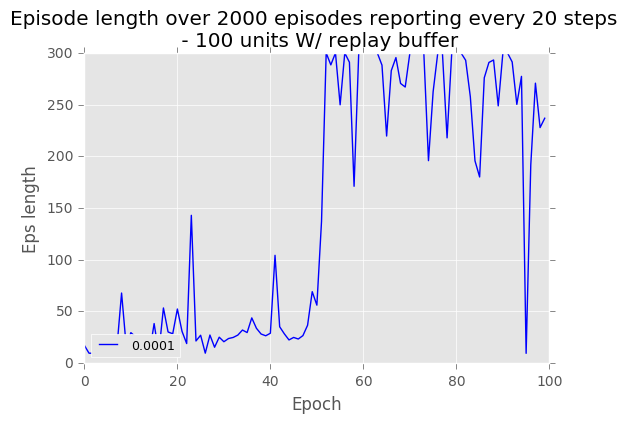

In [49]:
plot_eps_len(np.reshape(eps_le,[100,1]),100,'Episode length over 2000 episodes reporting every 20 steps \n - 100 units W/ replay buffer',lr_d)
plt.show()

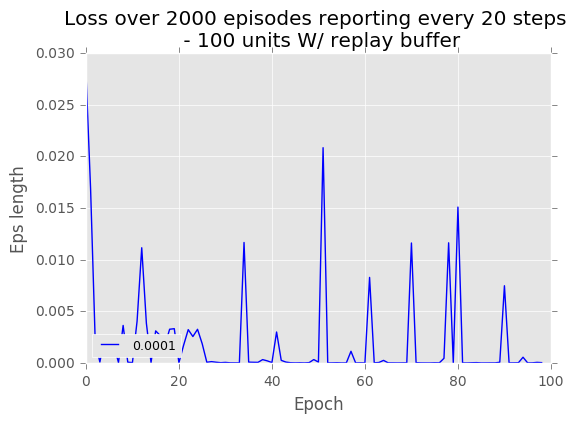

In [50]:
plot_eps_len(np.reshape(lo_List,[99,1]),99,'Loss over 2000 episodes reporting every 20 steps \n - 100 units W/ replay buffer',lr_d)
plt.show()

<h1> testing w/ saved weights </h1>

In [ ]:
tf.reset_default_graph()
save_MDir='/Users/onivron/trained_models/ass_3/weights/task_A_part_f/'
save_model = os.path.join(save_MDir,'accu')
states,s_ne,targetQ=plh()
Q,maxQ1,Q_prime,loss,trainer=graph(lr,states,s_ne,targetQ)
# restore model and calculate mean length and return over n_test episodes
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    saver.restore(sess = sess, save_path= save_model)
    print("Model for learning rate: ",lr_d[0])
    leng,ret = test_epoch(sess)
    print('Mean episode length:',leng)
    print('Mean return:',ret)

In [51]:
sess.close()

<h1>part G</h1>

In [52]:
y=.99
num_episodes=2000
num_eps_test=100
e=0.05
lr_d=[0.0001]
batchSize = 32
bufferx=100
h=0
lo=0

In [53]:
def plh():
    states=tf.placeholder(shape=[None,4],dtype=tf.float32) 
    nextQ = tf.placeholder(shape=[None,2],dtype=tf.float32)
    s_ne=tf.placeholder(shape=[None,4],dtype=tf.float32) 
    return(states,nextQ,s_ne)

In [54]:
def graph(states,nextQ):
    hidden_layer = {'W': tf.Variable(tf.random_uniform([4, 100], 0, 0.01)),
                    'b': tf.Variable(tf.random_uniform([100], 0, 0.01))}

    output_layer = {'W': tf.Variable(tf.random_uniform([100, 2], 0, 0.01)),
                    'b': tf.Variable(tf.random_uniform([2], 0, 0.01))}   
    h1= tf.nn.relu(tf.matmul(states,hidden_layer['W'])+ hidden_layer['b'])
    Q=tf.matmul(h1,output_layer['W'])+output_layer['b']
    loss = tf.reduce_mean(tf.square((nextQ) - Q))
    trainer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)
    return(Q,trainer,loss)

In [55]:
def graph_target(s_ne):
    hidden_layer_t = {'W': tf.Variable(tf.random_uniform([4, 100], 0, 0.01)),
                    'b': tf.Variable(tf.random_uniform([100], 0, 0.01))}

    output_layer_t = {'W': tf.Variable(tf.random_uniform([100, 2], 0, 0.01)),
                    'b': tf.Variable(tf.random_uniform([2], 0, 0.01))}
    h2_n = tf.nn.relu(tf.matmul(s_ne,hidden_layer_t['W'])+ hidden_layer_t['b'])
    Q_prime_n=tf.matmul(h2_n,output_layer_t['W'])+output_layer_t['b']
    maxQ1=tf.stop_gradient(tf.reduce_max(Q_prime_n,1))
    return(maxQ1)

In [56]:
def update_target_net(tf_vars, sess):
# Build list of copy operations
    num_vars = int(len(tf_vars)/2)  # 4 in each net (2 weights, 2 biases)
    op_list = []
    for idx, var in enumerate(tf_vars[0:num_vars]):
        op_list.append(tf_vars[idx+num_vars].assign(var.value()))
    # Run the TF operations to copy variables
    for op in op_list:
        sess.run(op)

In [58]:
def test_epoch(sess):
    eps_len=[]
    return_=[]
    for eps in range(num_eps_test):
        st_te=env.reset()
        st_te=np.reshape(st_te,[1,4])
        t=0
        while t < 300:
            t+=1
            test_Q=sess.run(Q,feed_dict={states:st_te})
            act=np.argmax(test_Q)
            new_st_te,re,done,_ = env.step(act)
            new_st_te=np.reshape(new_st_te,[1,4])
            st_te=new_st_te
            if (done==True):
                eps_len.append(t)
                tmp_rt=-1*y**t
                return_.append(tmp_rt)
                break                
    return(np.mean(eps_len),np.mean(return_))

In [59]:
#create lists to contain total rewards and steps per episode
all_loss=[]
replay = []
eps_le=[]
tf.reset_default_graph()
states,nextQ,s_ne=plh()
Q,trainer,loss=graph(states,nextQ)
maxQ1=graph_target(s_ne)
saver = tf.train.Saver(write_version = tf.train.SaverDef.V2)
sess=tf.Session() 
init = tf.global_variables_initializer()
sess.run(init)
for epoch in range(num_episodes):
    if (epoch%5==0):
        train_vars = tf.trainable_variables() 
        update_target_net(train_vars,sess)
    if epoch%20==0:
        length,ret=test_epoch(sess)
        eps_le.append(length)
    #Reset environment and get first new observation
    s = env.reset()
    s=np.reshape(s,[1,4])
    d = False
    j = 0
    #The Q-Network
    while j < 300:
        #env.render()
        j+=1
        allQ = sess.run(Q,feed_dict={states:s})
        if np.random.rand(1) < e:
            a=np.sum(np.random.uniform(0,1)>0.5)
        else:
            a=np.argmax(allQ)
        s1,r,d,_ = env.step(a)
        if (d==True):
            r=-1    
        else:
            r=0
        s1=np.reshape(s1,[1,4])
        #Experience replay storage
        if (len(replay) < bufferx): #if buffer not filled, add to it
            replay.append((s, a, r, s1))
        else: #if buffer full, overwrite old values
            if (h < (bufferx-1)):
                h += 1
            else:
                h = 0
            replay[h] = (s, a, r, s1)        
            observations=np.copy(replay)
            #randomly sample our experience replay memory
            batch_rows=np.random.randint(np.shape(observations)[0]-1, size=batchSize)
            batch_cur_st=np.reshape(np.concatenate(np.concatenate(observations[[batch_rows],0])),[batchSize,4])
            batch_nex_st=np.reshape(np.concatenate(np.concatenate(observations[[batch_rows],3])),[batchSize,4])
            actions=np.reshape(np.concatenate(observations[[batch_rows],1]),[batchSize,1])
            rewards=np.reshape(np.concatenate(observations[[batch_rows+1],2]),[batchSize,1])
            delta=rewards+1
            current_Q=sess.run(Q,feed_dict={states:batch_cur_st})
            target_Q=np.copy(current_Q)
            max_Q1=sess.run(maxQ1,feed_dict={s_ne:batch_nex_st})
            max_Q1=np.reshape(max_Q1,[batchSize,1])
            row_idx = np.array(range(batchSize))
            target_Q[row_idx[:,None],[actions]]=delta*y*max_Q1+rewards 
            _,lo=sess.run([trainer,loss],feed_dict={states:batch_cur_st,nextQ:target_Q})
        if (d==True):
            break
        s=s1
    if ((epoch%20==0) & (lo!=0)):
        all_loss.append(lo)
# save weights & graph when episodes finished
folder='/Users/onivron/trained_models/ass_3/weights/task_A_part_g/'
save_path=saver.save(sess,folder+'/accu')

/Users/onivron/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:61: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


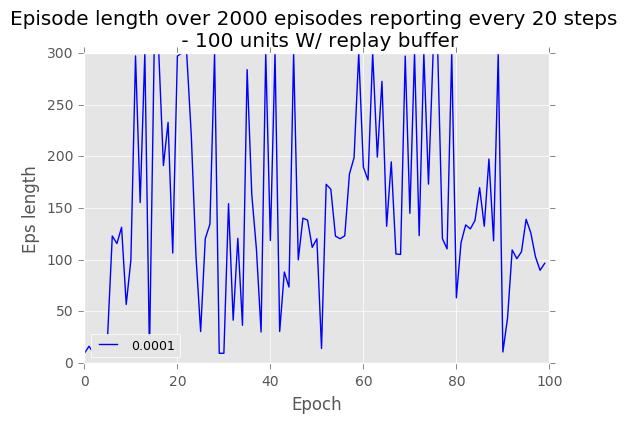

In [60]:
plot_eps_len(np.reshape(eps_le,[100,1]),100,'Episode length over 2000 episodes reporting every 20 steps \n - 100 units W/ replay buffer',lr_d)
plt.show()

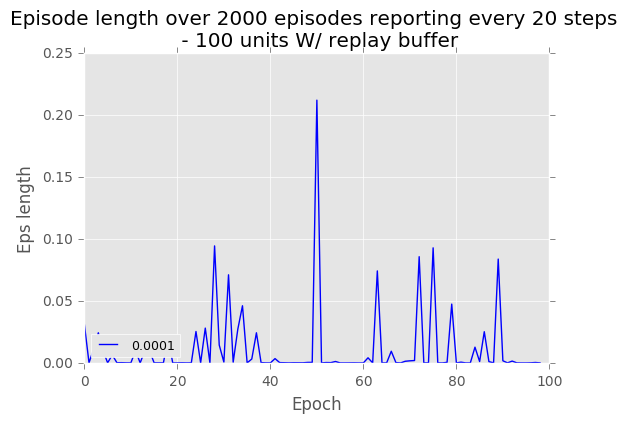

In [61]:
plot_eps_len(np.reshape(all_loss,[99,1]),99,'Episode length over 2000 episodes reporting every 20 steps \n - 100 units W/ replay buffer',lr_d)
plt.show()

<h1> testing w/ saved weights </h1>

In [ ]:
tf.reset_default_graph()
save_MDir='/Users/onivron/trained_models/ass_3/weights/task_A_part_g/'
save_model = os.path.join(save_MDir,'accu')
states,nextQ,s_ne=plh()
Q,trainer,loss=graph(states,nextQ)
maxQ1=graph_target(s_ne)
# restore model and calculate mean length and return over n_test episodes
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    saver.restore(sess = sess, save_path= save_model)
    print("Model for learning rate: ",lr_d[0])
    leng,ret = test_epoch(sess)
    print('Mean episode length:',leng)
    print('Mean return:',ret)

In [62]:
sess.close()

<h1>part H</h1>

In [ ]:
sess.close()